## DESEQ2 analysis of DMSO dataset

2 Factor design: 

* Treatment (DMSO v Control) 
* Cell Cycle (earlyG1, lateG1, SG2M) 

* 160,698 naive overlap peaks 
* 2 biological replicates per Sample (Treatment/CellCycle combination) 

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [2]:
#load ATAC-seq raw read counts
data=read.table('atac.counts.prededup.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$Chrom,data$Start,data$End,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL



In [3]:
head(data)

,earlyG1_controls_Rep1,earlyG1_controls_Rep2,earlyG1_DMSO_Rep1,earlyG1_DMSO_Rep2,lateG1_controls_Rep1,lateG1_controls_Rep2,lateG1_DMSO_Rep1,lateG1_DMSO_Rep2,SG2M_controls_Rep1,SG2M_controls_Rep2,SG2M_DMSO_Rep1,SG2M_DMSO_Rep2
chr1_10386_10664,390,406,360,437,419,350,306,620,273,204,272,182
chr1_713724_714583,277,264,269,278,253,222,210,297,177,177,209,169
chr1_762653_763015,57,61,69,65,73,53,45,76,48,37,56,53
chr1_780040_780288,29,27,16,17,30,21,14,22,21,20,4,11
chr1_781109_781347,47,43,20,18,43,31,4,40,38,36,2,14
chr1_804995_805671,68,85,82,90,92,64,60,79,66,69,63,52


In [4]:
#load the metadata
batches=read.table("../atacseq_batches_truerep.txt",header=TRUE,sep='\t',row.names=1)
batches$CellCycle=factor(batches$CellCycle)
batches$Treatment=factor(batches$Treatment)
batches$Sample=factor(batches$Sample)


In [5]:
head(batches)

,Sample,CellCycle,Treatment
earlyG1_controls_Rep1,earlyG1_controls,earlyG1,controls
earlyG1_controls_Rep2,earlyG1_controls,earlyG1,controls
earlyG1_DMSO_Rep1,earlyG1_DMSO,earlyG1,DMSO
earlyG1_DMSO_Rep2,earlyG1_DMSO,earlyG1,DMSO
lateG1_controls_Rep1,lateG1_controls,lateG1,controls
lateG1_controls_Rep2,lateG1_controls,lateG1,controls


## Perform surrogate variable analysis 

In [6]:
#svaseq
library(sva)
mod0=model.matrix(~1,data=batches)
mod1=model.matrix(~ Treatment + CellCycle,data=batches)
sva.obj=svaseq(as.matrix(data),mod1,mod0)
sur_var=data.frame(sva.obj$sv)




Loading required package: mgcv
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:IRanges’:

    collapse

This is mgcv 1.8-25. For overview type 'help("mgcv-package")'.
Loading required package: genefilter

Attaching package: ‘genefilter’

The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars



Number of significant surrogate variables is:  3 
Iteration (out of 5 ):1  2  3  4  5  

In [7]:
names(sur_var)=c("sv1","sv2","sv3")
batches=cbind(batches,sur_var)

In [8]:

#Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = data,
                              colData = batches,
                              design = ~CellCycle + CellCycle:Treatment+sv1)


## Visualizations 

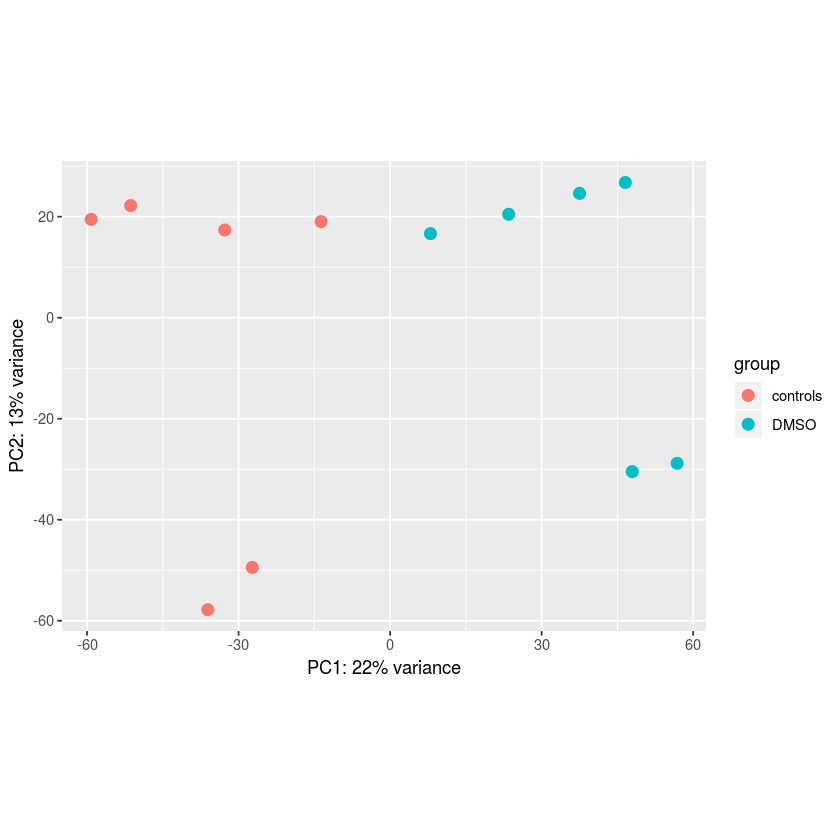

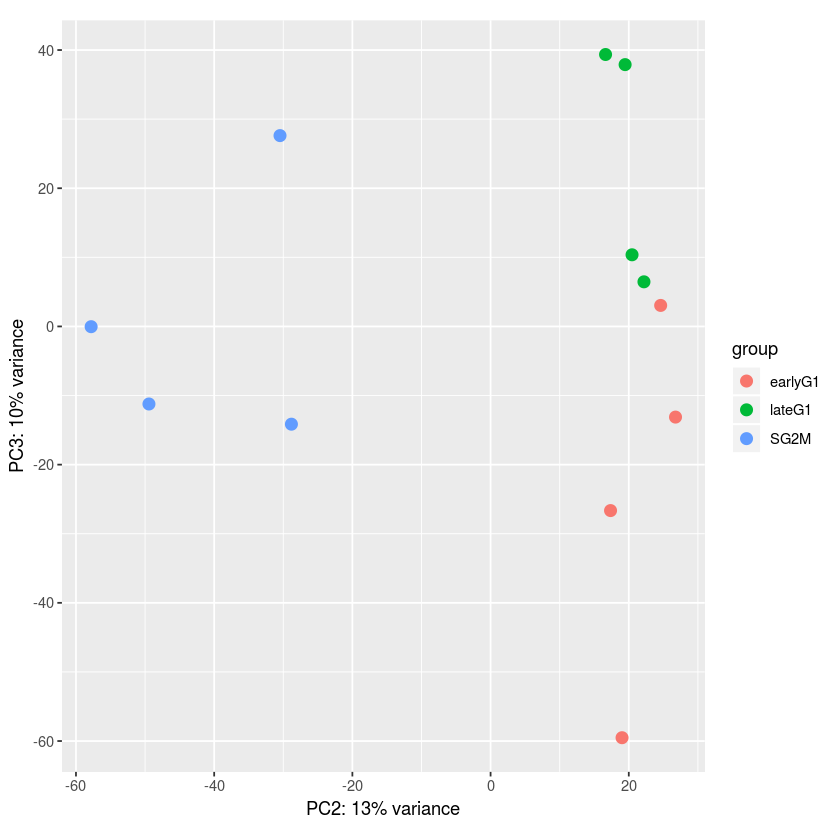

In [9]:
#PCA on vst-transformed data
vst_data=vst(dds)
source('plotPCA_custom.R')
plotPCA_custom(vst_data,intgroup=c("Treatment"),ntop=160698,returnData=FALSE,pcx=1,pcy=2)
plotPCA_custom(vst_data,intgroup=c("CellCycle"),ntop=160698,returnData=FALSE,pcx=2,pcy=3)


In [10]:
#perform size factor estimation for for housekeeping (HK) promoters
hk_promoters=read.table("HK.promoters.txt",header=TRUE,sep='\t')
hk_promoters=paste(hk_promoters$Chrom,hk_promoters$Start,hk_promoters$End,sep="_")
hk_promoter_indices=match(hk_promoters,rownames(data))


In [11]:
dds <- estimateSizeFactors(dds, controlGenes=hk_promoter_indices)


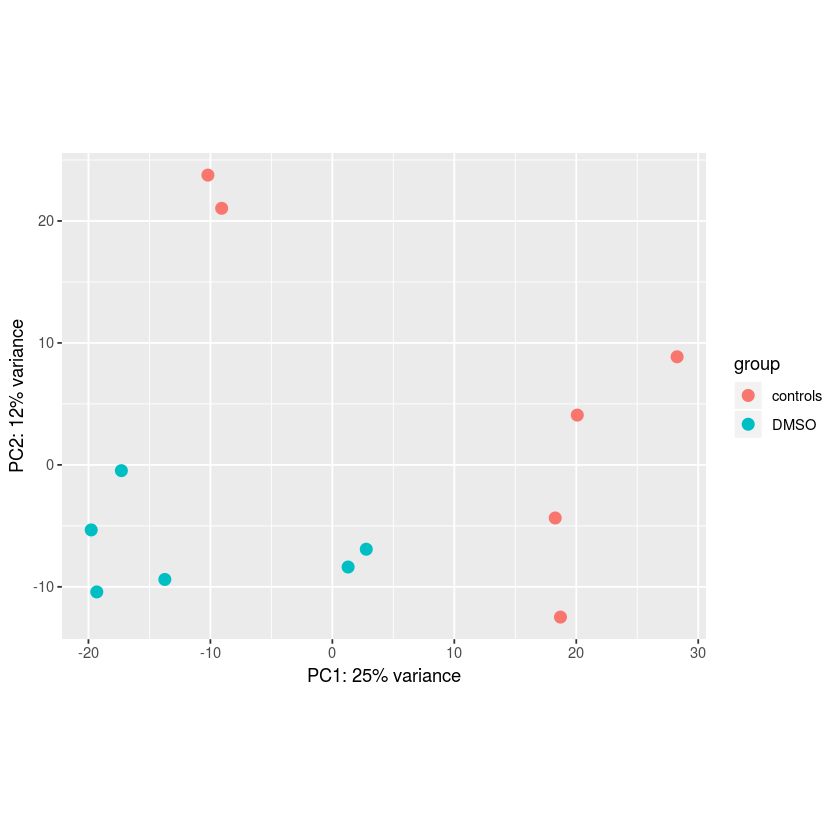

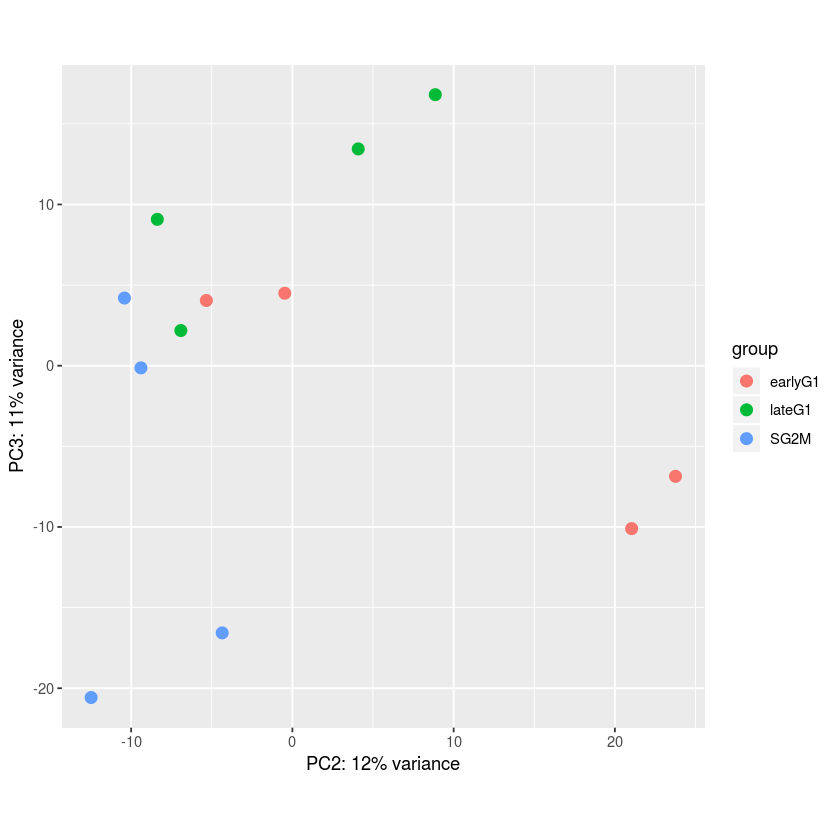

In [12]:
#PCA on vst-transformed data w/ custom sizeFactors
# shifted log of normalized counts
se <- SummarizedExperiment(log2(counts(dds, normalized=TRUE) + 1),
                           colData=colData(dds))
# the call to DESeqTransform() is needed to
# trigger our plotPCA method.
plotPCA_custom( DESeqTransform( se ),intgroup=c("Treatment"),pcx=1,pcy=2)
plotPCA_custom( DESeqTransform( se ),intgroup=c("CellCycle"),pcx=2,pcy=3)


## Extract and store normalized counts for further analysis 

In [13]:
normcounts=counts(dds,normalized=TRUE)
write.table(normcounts,"normcounts_from_deseq.txt",quote=FALSE,sep='\t',col.names=TRUE,row.names=TRUE)

## Differential Accessibility Operation

In [14]:
#Run the differential analysis
dds <- DESeq(dds,parallel = FALSE)


using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


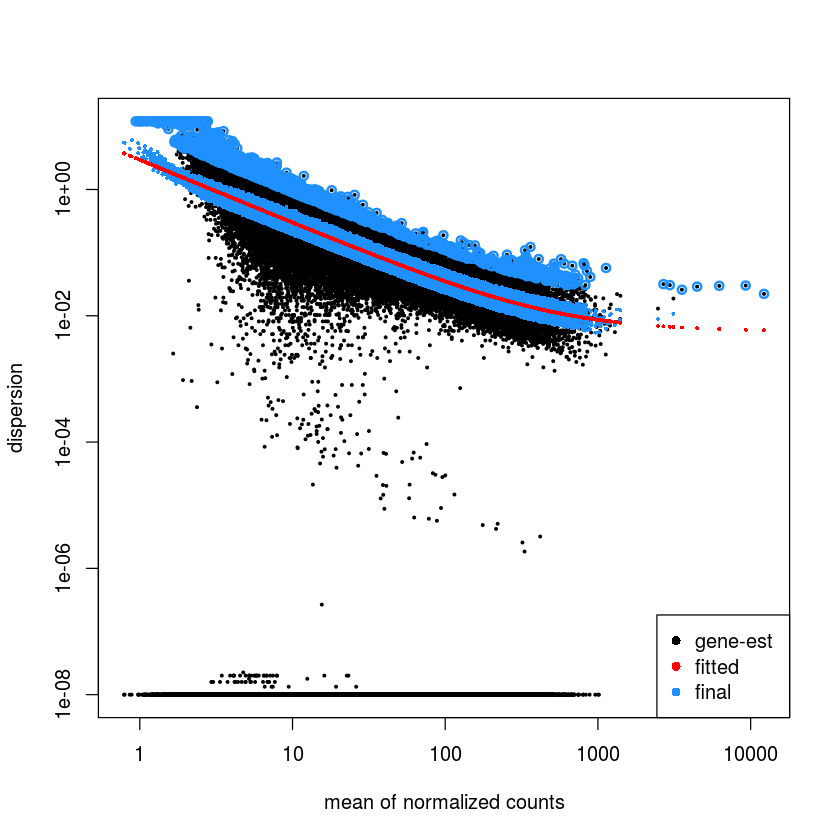

In [15]:
plotDispEsts(dds)


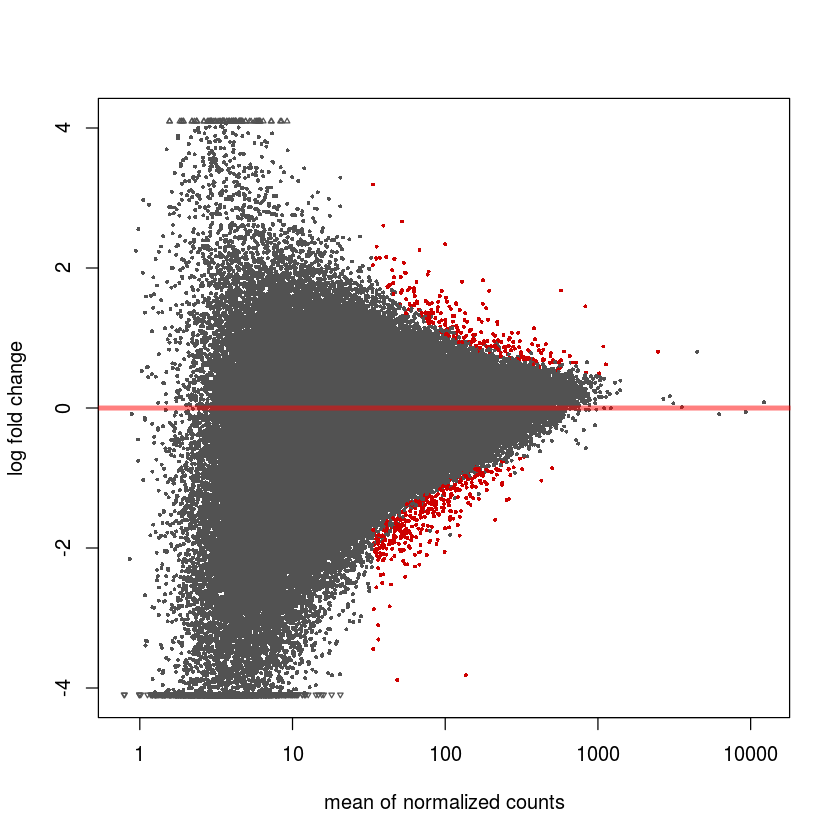

In [16]:
plotMA(dds)


## Standard BH Correction (no optimal thresholding) 

In [17]:
resultsNames(dds)

[1] "Intercept"                      "CellCycle_lateG1_vs_earlyG1"   
[3] "CellCycle_SG2M_vs_earlyG1"      "sv1"                           
[5] "CellCycleearlyG1.TreatmentDMSO" "CellCyclelateG1.TreatmentDMSO" 
[7] "CellCycleSG2M.TreatmentDMSO"

In [18]:
res=results(dds)
summary(res)


out of 160698 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 243, 0.15%
LFC < 0 (down)     : 363, 0.23%
outliers [1]       : 0, 0%
low counts [2]     : 102814, 64%
(mean count < 33)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [19]:
namesToOutput=c("CellCycle_lateG1_vs_earlyG1",
"CellCycle_SG2M_vs_earlyG1",
"CellCycleearlyG1.TreatmentDMSO",
"CellCyclelateG1.TreatmentDMSO",
"CellCycleSG2M.TreatmentDMSO")
numcomparisons=length(namesToOutput)

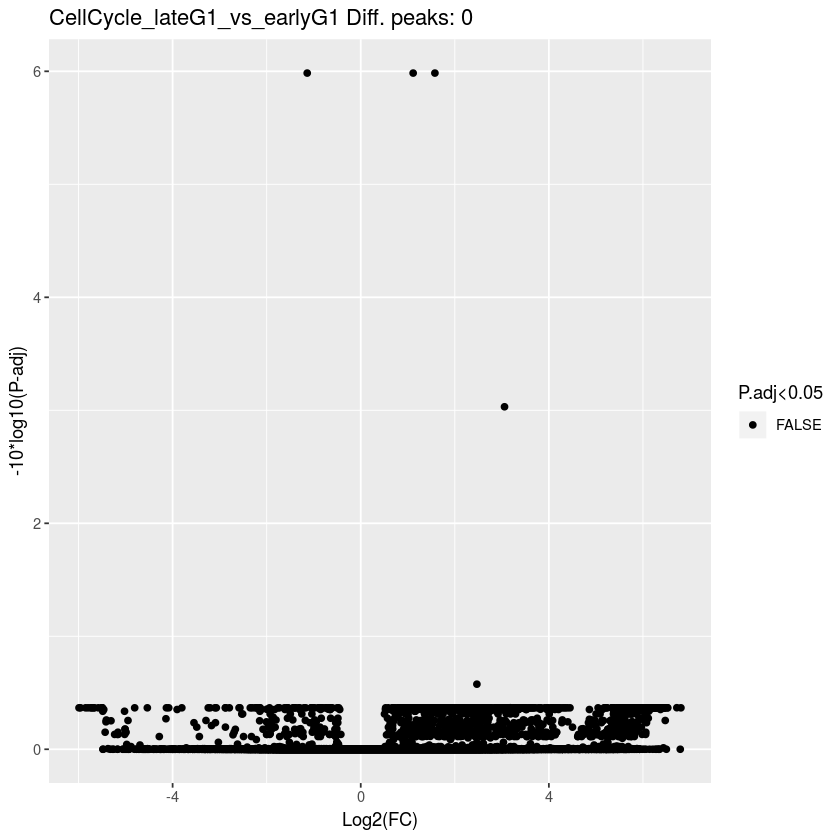

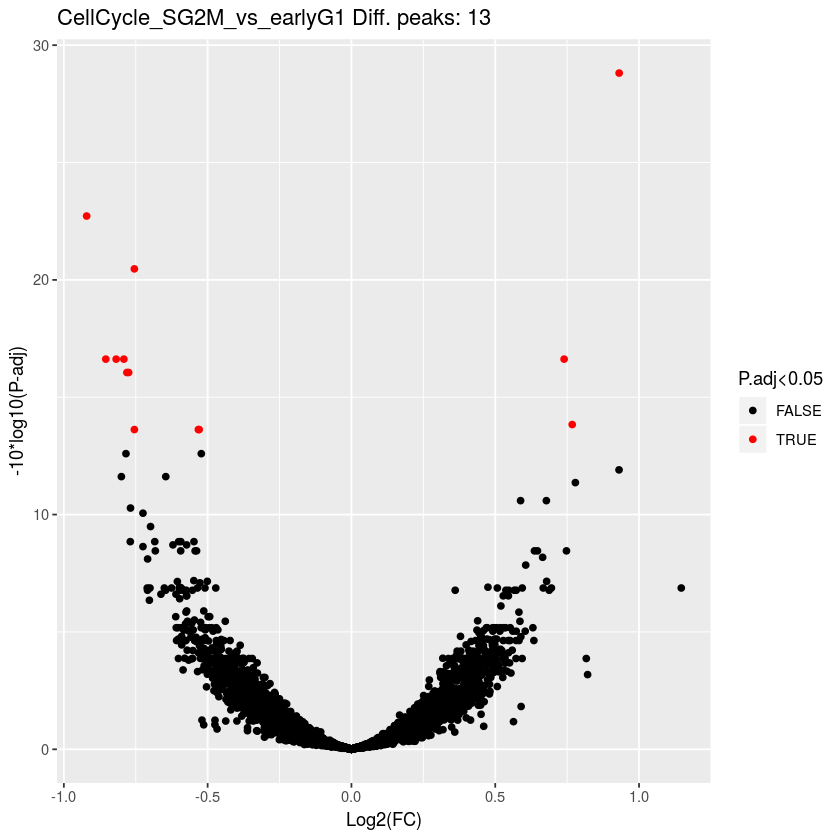

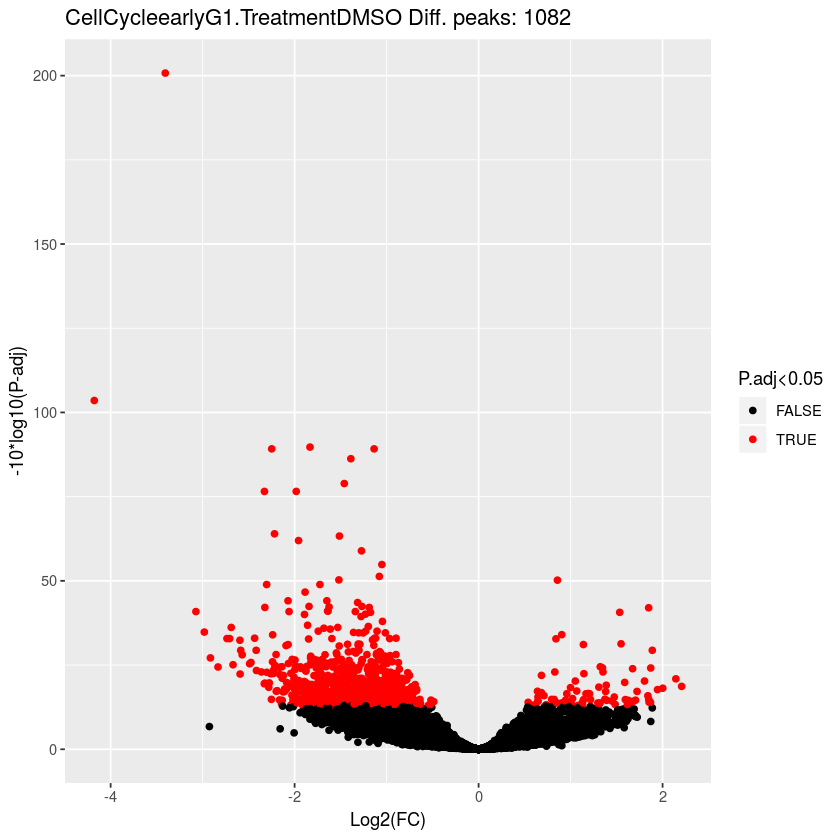

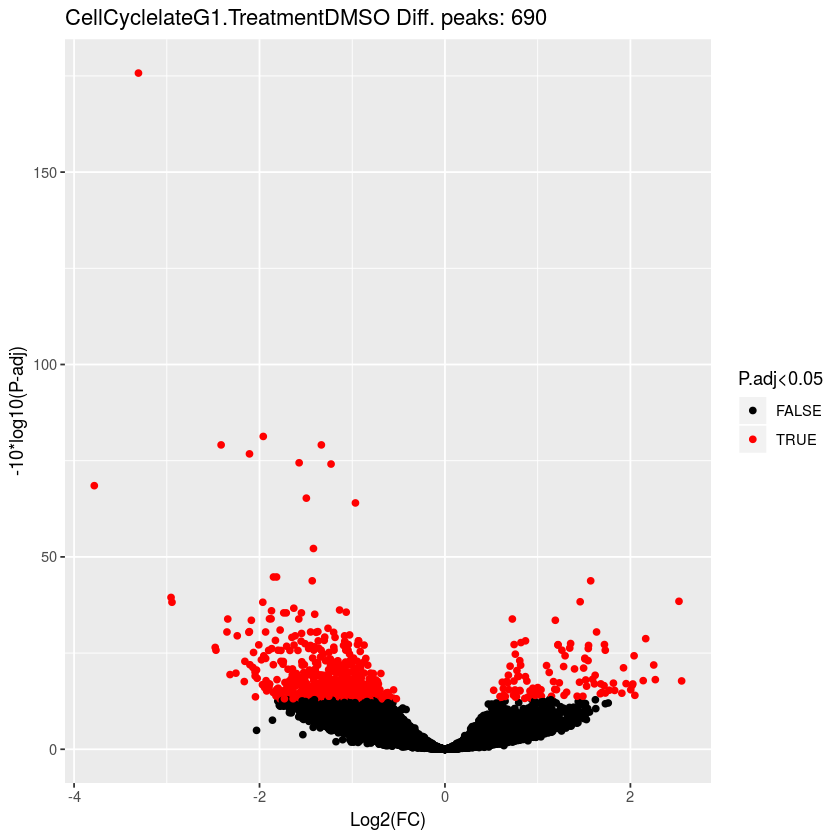

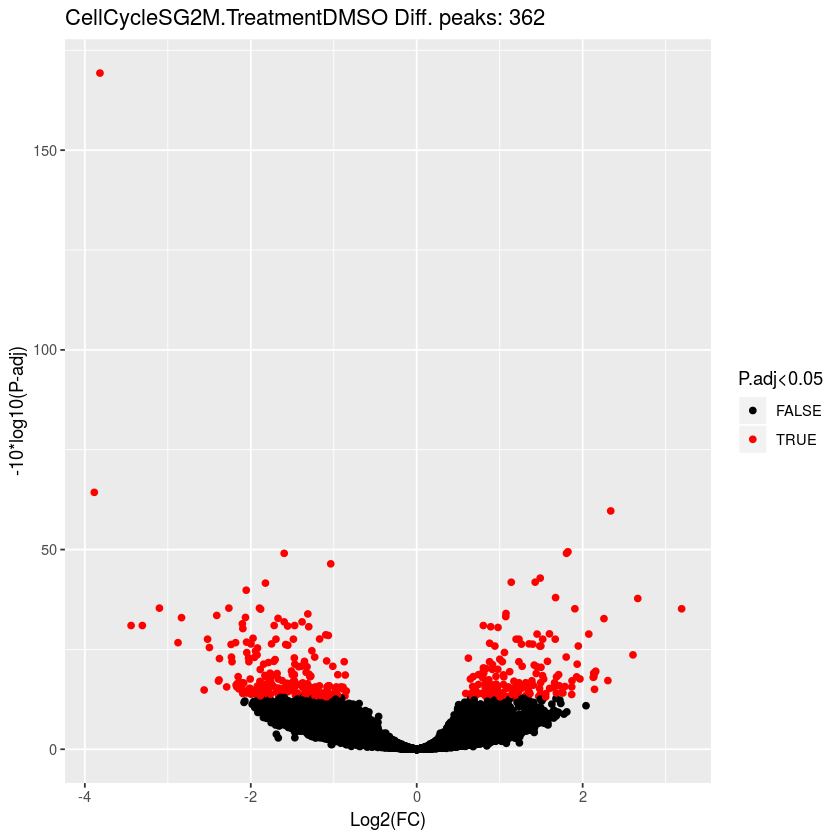

In [20]:
for(i in seq(1,numcomparisons))
{
 res=results(dds,name=namesToOutput[i],parallel=TRUE)
 res$logPadj=-10*log10(res$padj)
 res=as.data.frame(res)
 res=na.omit(res)
 numsig=sum(res$padj <= 0.05)
 sigsubset=res[res$padj<=0.05,]

 #output differential analysis results for the contrast
 outtable=paste(namesToOutput[i],"tsv",sep='.')
 write.table(sigsubset,file=outtable,quote=FALSE,sep='\t',row.names=TRUE,col.names=TRUE)

 #generate a volcano plot of the differential analysis for the contrast
 outpng=paste("volcano",namesToOutput[i],"png",sep='.')
 outlabel=paste(namesToOutput[i],"Diff. peaks:",numsig)
 res$color=res$padj<=0.05

 #png(outpng)#,width=5,height=5,pointsize=12)
 print(ggplot(data=res,
        aes(x=res$log2FoldChange,
            y=res$logPadj,
            color=res$color))+
        geom_point()+
        xlab("Log2(FC)")+
        ylab("-10*log10(P-adj)")+
        ggtitle(outlabel)+
        scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05"))
 #dev.off()
}


## Find an Optimal Filtering Threshold with -log10Pval v baseMean

In [21]:
res=results(dds)
res$filtRatio=-log10(res$pvalue)/res$baseMean
res_df=as.data.frame(res[order(-res$filtRatio),])

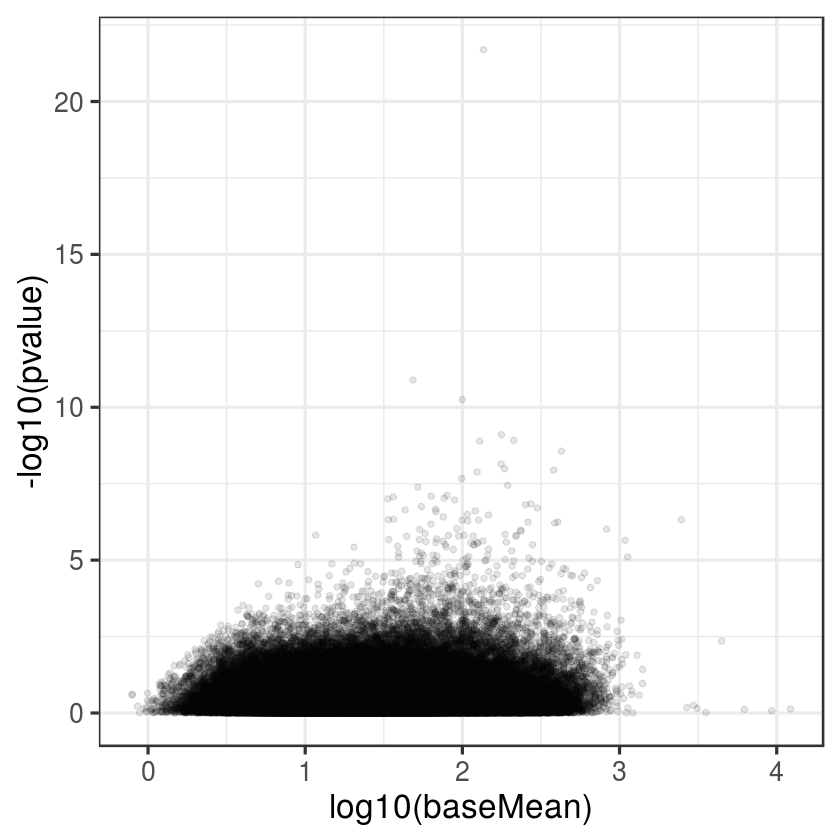

In [22]:
ggplot(data=res_df,
       aes(x=log10(res_df$baseMean),
           y=-log10(res_df$pvalue)))+
       geom_point(alpha=0.1)+
       xlab("log10(baseMean)")+
       ylab("-log10(pvalue)")+
       theme_bw(20)
       
       


## Find an optimal filtering threshold with IHW

In [23]:
library("IHW")
resIHW=results(dds,filterFun=ihw)
summary(resIHW)


out of 160698 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 300, 0.19%
LFC < 0 (down)     : 376, 0.23%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



In [24]:
sum(resIHW$padj < 0.1, na.rm=TRUE)



[1] 676

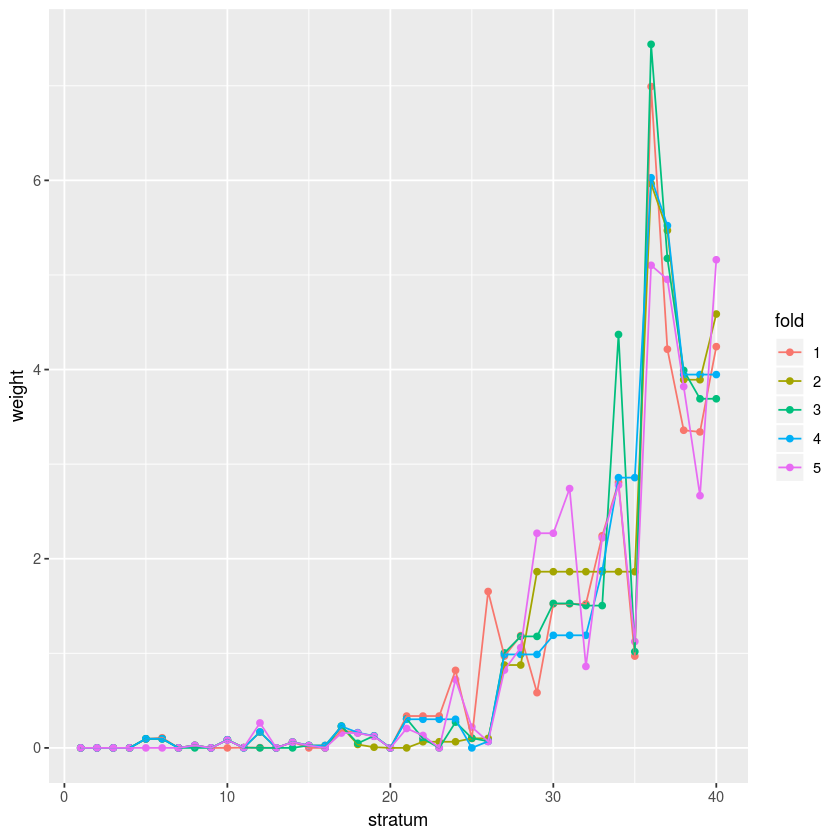

In [25]:
plot(metadata(resIHW)$ihwResult)



## Independent Filtering 

In [26]:
metadata(res)$alpha


[1] 0.1

In [27]:
metadata(res)$filterThreshold


63.97959% 
 33.37513

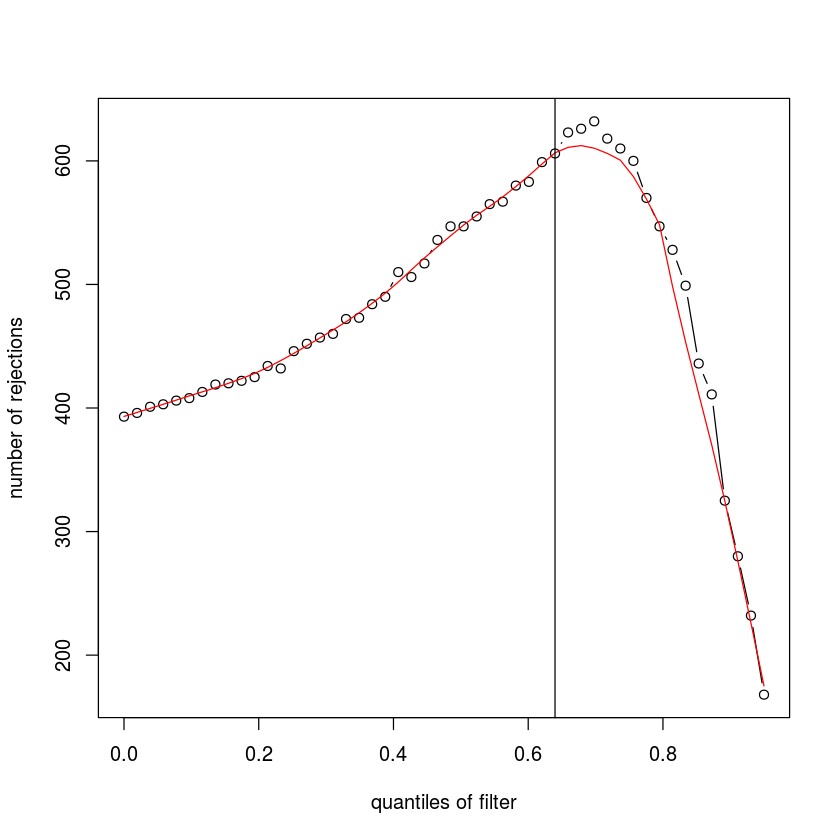

In [28]:
plot(metadata(res)$filterNumRej, 
     type="b", ylab="number of rejections",
     xlab="quantiles of filter")
lines(metadata(res)$lo.fit, col="red")
abline(v=metadata(res)$filterTheta)

In [29]:
resNoFilt <- results(dds, independentFiltering=FALSE)
addmargins(table(filtering=(res$padj < .1),
                 noFiltering=(resNoFilt$padj < .1)))

,FALSE,TRUE,Sum
FALSE,57278,0,57278
TRUE,273,333,606
Sum,57551,333,57884


In [30]:
summary(resNoFilt)


out of 160698 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 147, 0.091%
LFC < 0 (down)     : 246, 0.15%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## plotCounts for top 5 peaks -- QC 

In [31]:
res=results(dds)
res_df=as.data.frame(res[order(res$padj),])

head(res_df)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
chr2_67567266_67568255,136.40044,-3.818072,0.3919866,-9.740313,2.029292e-22,1.174636e-17
chr2_67565766_67566547,48.44927,-3.886311,0.5739398,-6.771287,1.276422e-11,3.694220e-07
chr8_2970425_2970925,99.99090,2.337957,0.3567009,6.554390,5.586983e-11,1.077990e-06
chr6_167648991_167650125,177.02106,1.822555,0.2964514,6.147906,7.851239e-10,1.136153e-05
chr20_44211844_44212483,212.23681,-1.597508,0.2627817,-6.079220,1.207688e-09,1.241678e-05
chr9_21751914_21752493,128.58502,1.805056,0.2974221,6.069003,1.287069e-09,1.241678e-05


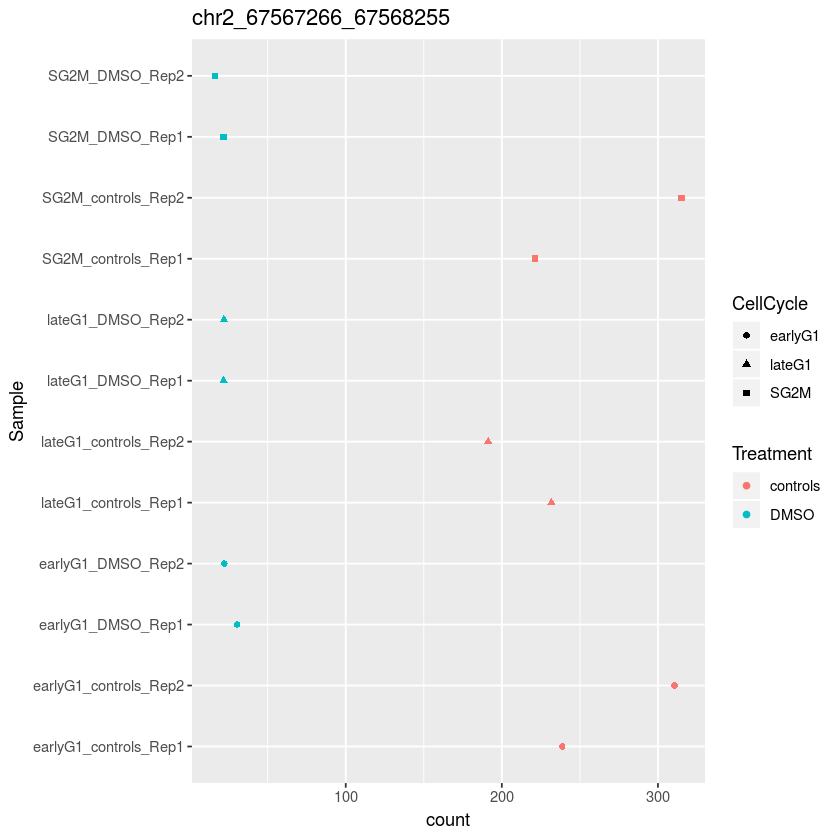

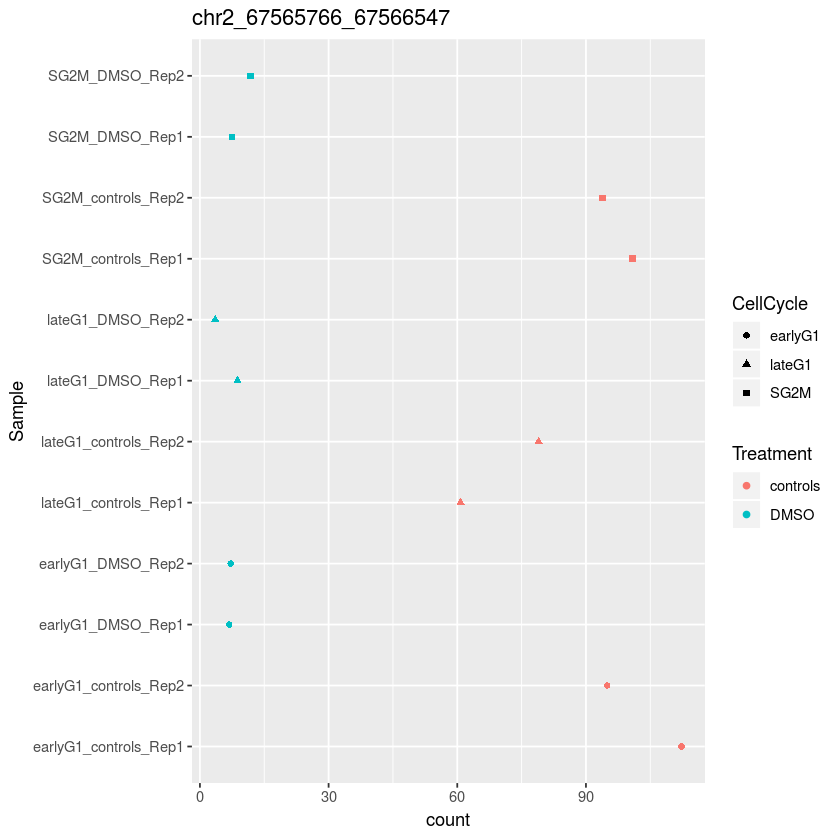

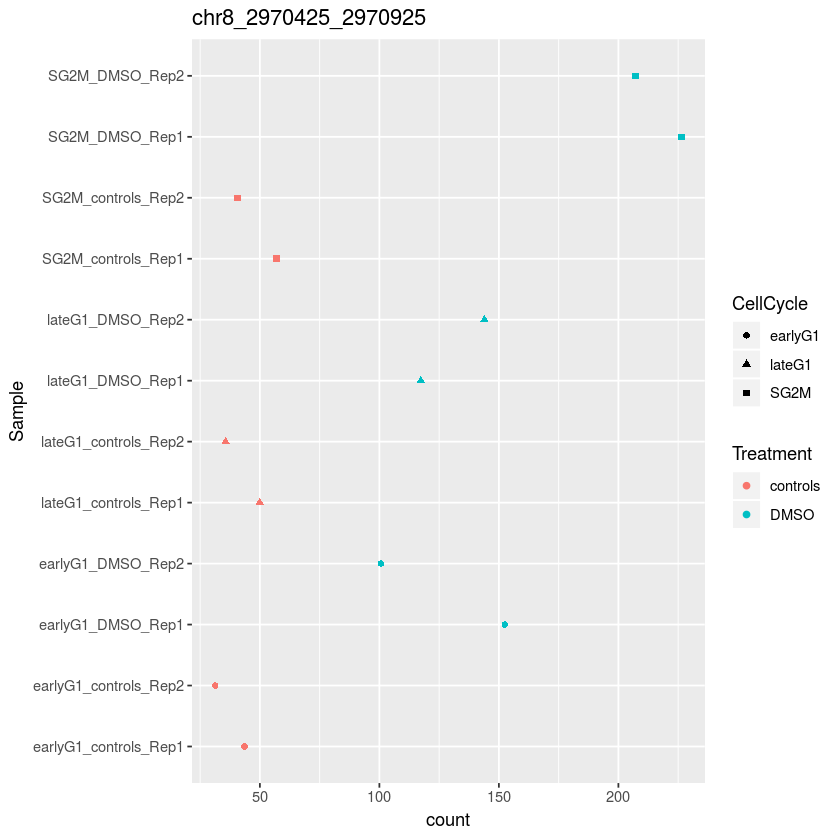

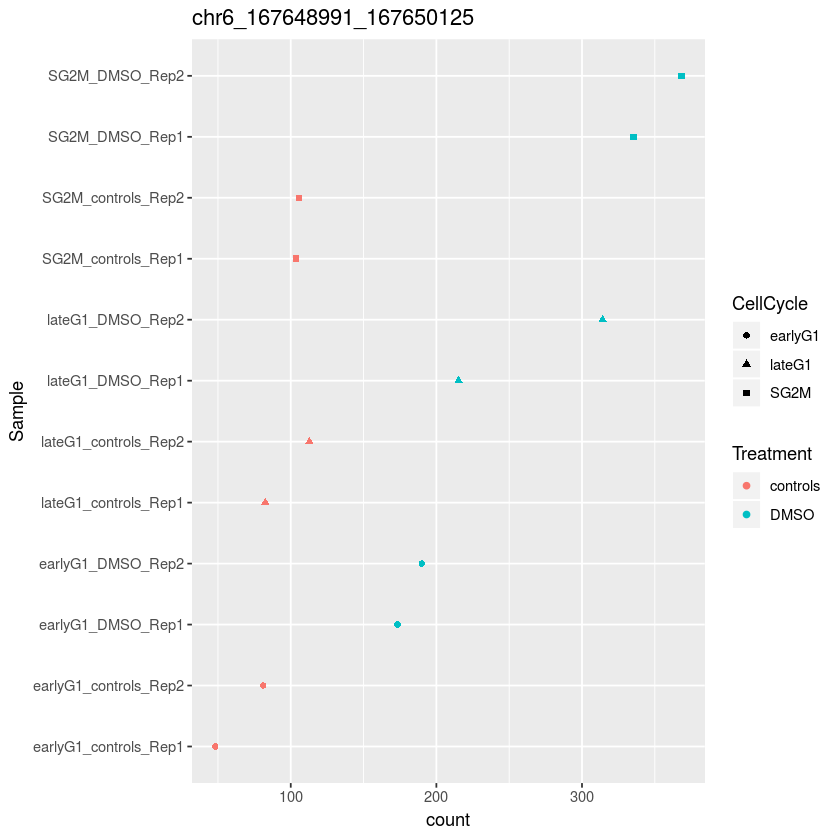

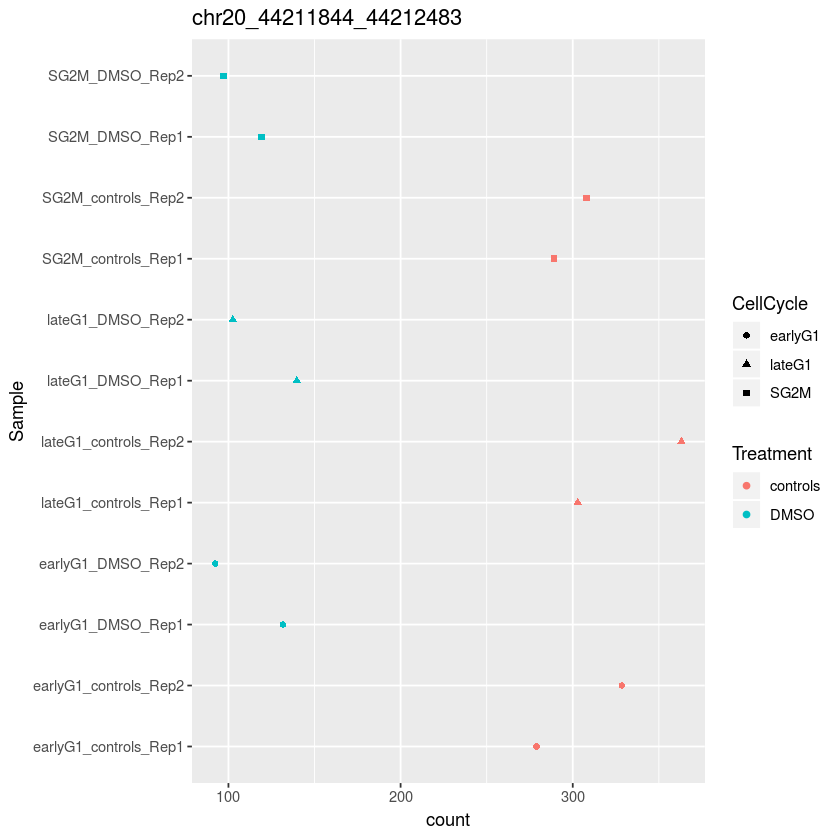

In [32]:
hitnames=rownames(res_df)[1:5]
for(i in hitnames){
topHit=plotCounts(dds, gene=i, intgroup=c("Treatment","CellCycle"),returnData=TRUE)
topHit$Sample=rownames(topHit)
print(ggplot(data=topHit,
       aes(x=Sample,
          y=count,
          color=Treatment,
          shape=CellCycle))+
geom_point()+
coord_flip()+
ggtitle(i))
    }